In [44]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator
from sklearn.ensemble import AdaBoostClassifier
import tqdm
import matplotlib.pyplot as plt
import timeit

Read the data

In [2]:
data = pd.read_csv('diabetes.csv')

Show several lines

In [3]:
data.iloc[:10, :]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


The dataset has no missing data, we don't need to fill NaNs, but we have to normalize them. I use MinMaxScaler (to be in 0-1)

In [4]:
data = MinMaxScaler((-1, 1)).fit_transform(data)

In [5]:
data

array([[-0.29411765,  0.48743719,  0.18032787, ..., -0.53116994,
        -0.03333333,  1.        ],
       [-0.88235294, -0.14572864,  0.08196721, ..., -0.76686593,
        -0.66666667, -1.        ],
       [-0.05882353,  0.83919598,  0.04918033, ..., -0.49274125,
        -0.63333333,  1.        ],
       ...,
       [-0.41176471,  0.2160804 ,  0.18032787, ..., -0.85738685,
        -0.7       , -1.        ],
       [-0.88235294,  0.26633166, -0.01639344, ..., -0.76857387,
        -0.13333333,  1.        ],
       [-0.88235294, -0.06532663,  0.14754098, ..., -0.79760888,
        -0.93333333, -1.        ]])

In [6]:
X, y = torch.from_numpy(data[:, :-1]), torch.from_numpy(data[:, -1])

Metrics: 10-fold cross validation

In [7]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 12345)

Our perceptron

In [34]:
class Perceptron(BaseEstimator):
    def __init__(self, eta = 0.001, max_iter = 100):
        self.eta = eta
        self.max_iter = max_iter
    def fit(self, X, y):
        self.n_features  = X.shape[1]
        self.n_rows      = X.shape[0]
        self.weights     = torch.zeros((self.n_features, ), dtype=X.dtype)
        self.bias        = torch.tensor(0.0)
        self.history     = []
        self.best_score_ = 0.0
        self.best_weights_ = torch.zeros((self.n_features, ), dtype=X.dtype)
        #for i in tqdm.tqdm(range(self.max_iter)):
        for i in range(self.max_iter):
            for j in range(self.n_rows):
                a = 1 if torch.dot(self.weights, X[j]) + self.bias >= 0 else -1
                if y[j] * a < 0:
                    update = y[j] * X[j]
                    self.weights += update * self.eta
                    self.bias += y[j] * self.eta
            score = self.score(X, y)
            #if self.best_score_ < score:
            #    self.best_score_ = score
            #    self.best_weights = self.weights + 0.0
            self.history.append(score)

    def predict(self, X):
        yh = torch.zeros((X.shape[0], ))
        for i in range(X.shape[0]):
            yh[i] = 1 if torch.dot(self.weights, X[i]) + self.bias >= 0 else -1
        return yh
    def score(self, X, y):
        yh = self.predict(X)
        return (torch.sum(yh == y) / X.shape[0]).item()
        
        

In [35]:
p = Perceptron()
p.fit(X, y)

In [10]:
n = X.shape[0] * 4 // 5
X_train, X_test = X[:n, :], X[n:, :]
y_train, y_test = y[:n], y[n:]


In [11]:
p.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.31it/s]


In [12]:
p.score(X_train, y_train)

0.7589576840400696

In [13]:
p.score(X_test, y_test)

0.7727272510528564

In [14]:
score = cross_val_score(p, X, y, cv=cv)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.34it/s]


In [15]:
score

array([0.67532468, 0.49350649, 0.71428573, 0.58441556, 0.70129871,
       0.81818181, 0.64935064, 0.70129871, 0.65789473, 0.47368422])

In [16]:
torch.mean(torch.Tensor(score))

tensor(0.6469)

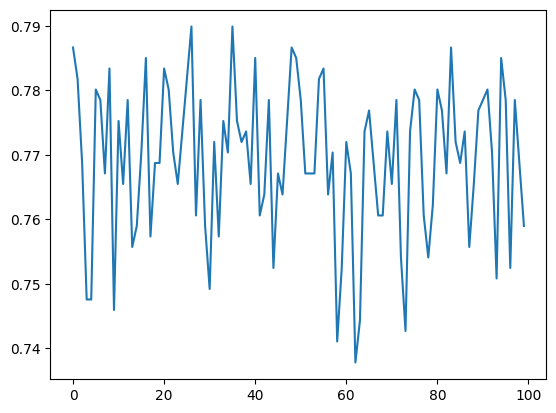

In [17]:
plt.plot(p.history)

In [19]:
import sklearn.linear_model
skPerceptron = sklearn.linear_model.Perceptron

In [20]:
q = Perceptron()

In [21]:
q.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.22it/s]


In [22]:
print(q.score(X_test, y_test))

0.7727272510528564


In [23]:
print(q.score(X_train, y_train))

0.7589576840400696


In [24]:
cmp_score = cross_val_score(q, X, y, cv=cv)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.48it/s]


In [25]:
torch.mean(torch.from_numpy(cmp_score))

tensor(0.6469, dtype=torch.float64)

In [31]:
def experiment(eta, max_iter):
    p = Perceptron(eta, max_iter)
    q = skPerceptron(eta0 = eta, max_iter = max_iter, random_state = 1234)
    t1 = timeit.timeit(lambda: p.fit(X_train, y_train), number=1)
    t2 = timeit.timeit(lambda: q.fit(X_train, y_train), number=100) / 100.0
    c1 = p.score(X_test, y_test)
    c2 = q.score(X_test, y_test)
    cv1 = torch.mean(torch.from_numpy(cross_val_score(p, X, y, cv = cv))).item()
    cv2 = torch.mean(torch.from_numpy(cross_val_score(q, X, y, cv = cv))).item()
    return [t1, t2, c1, c2, cv1, cv2]

In [38]:
data = []
for eta in (0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1):
    for max_iter in (10, 20, 50, 100, 200, 500):
        print(eta, max_iter)
        r = [eta, max_iter]
        ret = experiment(eta, max_iter)
        r += ret
        data.append(r)

0.01 10
0.01 20
0.01 50
0.01 100
0.01 200
0.01 500
0.02 10
0.02 20
0.02 50
0.02 100
0.02 200
0.02 500
0.05 10
0.05 20
0.05 50
0.05 100
0.05 200
0.05 500
0.1 10


/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.1 20
0.1 50
0.1 100
0.1 200
0.1 500
0.2 10


/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.2 20
0.2 50
0.2 100
0.2 200
0.2 500
0.5 10


/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.5 20
0.5 50
0.5 100
0.5 200
0.5 500
1 10


/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/mini/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1 20
1 50
1 100
1 200
1 500


In [39]:
data

[[0.01,
  10,
  0.1602353910002421,
  0.0005555252799968002,
  0.7272727489471436,
  0.6558441558441559,
  0.7018626153469085,
  0.7043745727956254],
 [0.01,
  20,
  0.27644268900075986,
  0.0005414376099997753,
  0.7337662577629089,
  0.6558441558441559,
  0.6666097044944763,
  0.7043745727956254],
 [0.01,
  50,
  0.7194095550003112,
  0.0006432524199954059,
  0.7532467246055603,
  0.6558441558441559,
  0.643010938167572,
  0.7043745727956254],
 [0.01,
  100,
  1.470468845999676,
  0.0005789631200059375,
  0.7727272510528564,
  0.6558441558441559,
  0.6469241291284561,
  0.7043745727956254],
 [0.01,
  200,
  2.8019917390001865,
  0.0005400670600010926,
  0.7142857313156128,
  0.6558441558441559,
  0.7083048582077026,
  0.7043745727956254],
 [0.01,
  500,
  7.067464597999788,
  0.0005509332199926575,
  0.7402597665786743,
  0.6558441558441559,
  0.6418489336967468,
  0.7043745727956254],
 [0.02,
  10,
  0.14316053000038664,
  0.0005349226599992107,
  0.7272727489471436,
  0.65584415584

In [43]:
for d in data:
    d[2:] = [ "%.02f" % x for x in d[2:]]
    print("|".join(map(str, d)))
    

0.01|10|0.16|0.00|0.73|0.66|0.70|0.70
0.01|20|0.28|0.00|0.73|0.66|0.67|0.70
0.01|50|0.72|0.00|0.75|0.66|0.64|0.70
0.01|100|1.47|0.00|0.77|0.66|0.65|0.70
0.01|200|2.80|0.00|0.71|0.66|0.71|0.70
0.01|500|7.07|0.00|0.74|0.66|0.64|0.70
0.02|10|0.14|0.00|0.73|0.66|0.70|0.70
0.02|20|0.28|0.00|0.73|0.66|0.67|0.70
0.02|50|0.72|0.00|0.75|0.66|0.64|0.70
0.02|100|1.44|0.00|0.77|0.66|0.65|0.70
0.02|200|2.89|0.00|0.71|0.66|0.71|0.70
0.02|500|7.16|0.00|0.74|0.66|0.64|0.70
0.05|10|0.14|0.00|0.73|0.72|0.70|0.69
0.05|20|0.28|0.00|0.73|0.72|0.67|0.69
0.05|50|0.74|0.00|0.75|0.72|0.64|0.69
0.05|100|1.45|0.00|0.77|0.72|0.65|0.69
0.05|200|2.90|0.00|0.71|0.72|0.71|0.69
0.05|500|7.24|0.00|0.74|0.72|0.63|0.69
0.1|10|0.14|0.00|0.73|0.72|0.70|0.72
0.1|20|0.32|0.00|0.73|0.72|0.67|0.72
0.1|50|0.71|0.00|0.75|0.72|0.64|0.72
0.1|100|1.41|0.00|0.77|0.72|0.65|0.72
0.1|200|2.89|0.00|0.71|0.72|0.71|0.72
0.1|500|7.13|0.00|0.74|0.72|0.63|0.72
0.2|10|0.14|0.00|0.73|0.72|0.70|0.72
0.2|20|0.31|0.00|0.73|0.72|0.67|0.72
0.2|50|0